# **Categorical Encodings Made Easy: An Overview of Techniques**

### **Note: More complete notebook on Categorical Encoding :**

**Cats on a Hot Tin Roof: Cats Encoding Methods**

https://www.kaggle.com/arashnic/cats-on-a-hot-tin-roof-cats-encoding-methods

## **Introduction**

The performance of a machine learning model not only depends on the model and the hyperparameters but also on how we process and feed different types of variables to the model. Since most machine learning models only accept numerical variables, preprocessing the categorical variables becomes a necessary step. We need to convert these categorical variables to numbers such that the model is able to understand and extract valuable information.



Usually there are 2 kinds of categorical data:

- Ordinal Data: The categories have an inherent order
in Job Change dataset are:[ 'education_level', 'experience','company_size','last_new_job']
- Nominal Data: The categories do not have an inherent order 
in Job chanege dataset are:['city','gender','enrolled_university','major_discipline', 'company_type','relevent_experience',]
*(binary data could be nominal or ordinal)*

Generally:
In Ordinal data, while encoding, one should retain the information regarding the order in which the category is provided. 

While encoding Nominal data, we have to consider the presence or absence of a feature. In such a case, no notion of order is present. 





So how should we select encoding methods is depends algorithm(s) we apply :
        
- Some algorithms can work with categorical data directly e.g LightGBM , CatBoost , or For example, a decision tree can be learned directly from categorical data with no data transform required (this depends on the specific implementation).

- Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.

- Some implementations of machine learning algorithms require all data to be numerical. For example, scikit-learn has this requirement.

- If we categorize algorithms to linear and tree based models we sholuld consider that generally linear models are sensitive to order of ordinal data so we should select appropriate encoding methods. 





![gif](https://lh3.googleusercontent.com/YyC6zhZXIRLiLa87ISWdqwujDaNENXkf1ZqLV6JSKB8a-NGn5aVD0WdRYuookPv9Bfr9-danuXOhfweUGJBMfY9QS59KdxXHspfWRj9e26x9HgiMjEcXP2Jp8IlibnDiLst_sr5P)

>## **Content:**
>    
>#### 1. Quick EDA
>#### 2. Label Encoding, Ordinal Encoding
>#### 3. One-Hot Encoding, Dummy Encoding
>#### 4. Frequency Encoding
>#### 5. Target Encoding
>#### 6. Hash Encoding
>#### 7. Weight of Evidence
>#### 8. CatBoost and Cats
>#### 9. LightGBM and Cats


>In this noteboo we will review some encoding techniques along side with applying some algorithms and base models, mostly with class weight as a technique to handle imbamced data. In most models using class weight parameter prevented overfiting and boosted the performance .  All models are as base and boosting is possible by applying advanced feat eng, feat selection, model tuning, applying other techniques for handling imbalanced data , ensemblibg and so on.

Morever different imputing techniques applied according the applied algorithm . Some linear models required scaling before feeding to the models. You can apply your ideas on based models to boost performance.    


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/job-change-dataset-answer/jobchange_test_target_values.npy
/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.style.use('fivethirtyeight')
from scipy import stats
from scipy.stats import rankdata, norm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis


from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, OrthogonalMatchingPursuit
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import time, os, warnings, random, string, re, gc, sys

import category_encoders as ce

import lightgbm as lgb
import catboost as cb



if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython.display import display
pd.set_option('display.max_colwidth', 300)

def set_seed(seed=4242):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()



In [3]:
train = pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
test = pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv')
answer = np.load('/kaggle/input/job-change-dataset-answer/jobchange_test_target_values.npy')

train.shape, test.shape, answer.shape

((19158, 14), (2129, 13), (2129,))

## **Quick EDA**

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
cats = [c for c in train.columns if train[c].dtypes=='object']
cats

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

Changin column name to be identified nominals and ordinals:

In [6]:
train.columns = ['enrollee_id', 'city_nom', 'city_development_index', 'gender_nom',
       'relevent_experience_nom', 'enrolled_university_nom', 'education_level_ord',
       'major_discipline_nom', 'experience_ord', 'company_size_ord', 'company_type_nom',
       'last_new_job_ord', 'training_hours', 'target']

test.columns = ['enrollee_id', 'city_nom', 'city_development_index', 'gender_nom',
       'relevent_experience_nom', 'enrolled_university_nom', 'education_level_ord',
       'major_discipline_nom', 'experience_ord', 'company_size_ord', 'company_type_nom',
       'last_new_job_ord', 'training_hours']

ordinals= [c for c in train.columns if 'ord' in c]
nominals = [c for c in train.columns if 'nom' in c]
ordinals

['education_level_ord',
 'experience_ord',
 'company_size_ord',
 'last_new_job_ord']

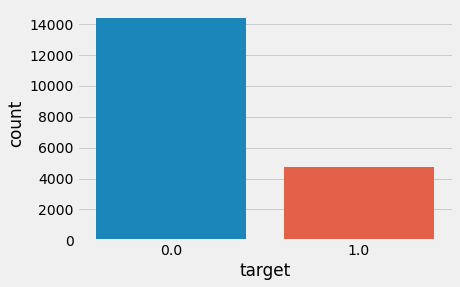

In [7]:
tr_orig = train.copy()
ts_orig = test.copy()

sns.countplot(train.target)

### Numerics

Text(0.5, 1.0, 'Train Vs Test')

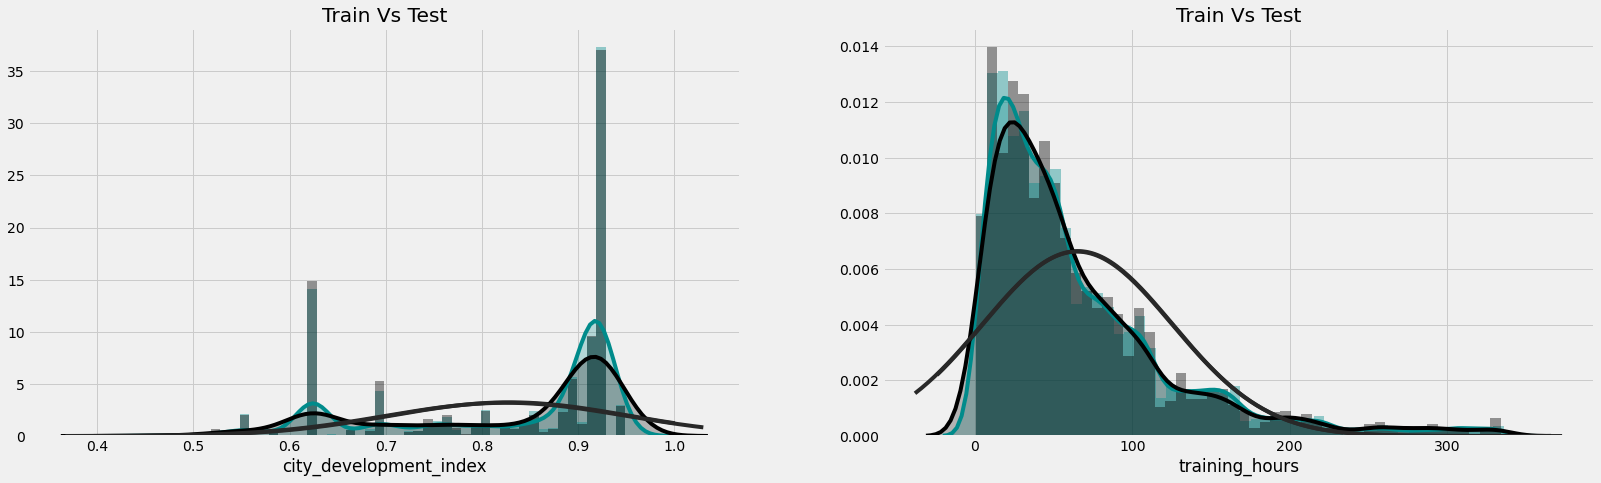

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(25, 7))
sns.distplot(train.city_development_index,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='darkcyan', ax=axs[0])
sns.distplot(train.training_hours,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='darkcyan', ax=axs[1])
axs[0].set_title('Train Vs Test')
sns.distplot(test.city_development_index,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='k', ax=axs[0])
sns.distplot(test.training_hours,bins=50,  fit=norm,kde=True,kde_kws={"shade": True},norm_hist=True,  color='k', ax=axs[1])
axs[1].set_title('Train Vs Test')

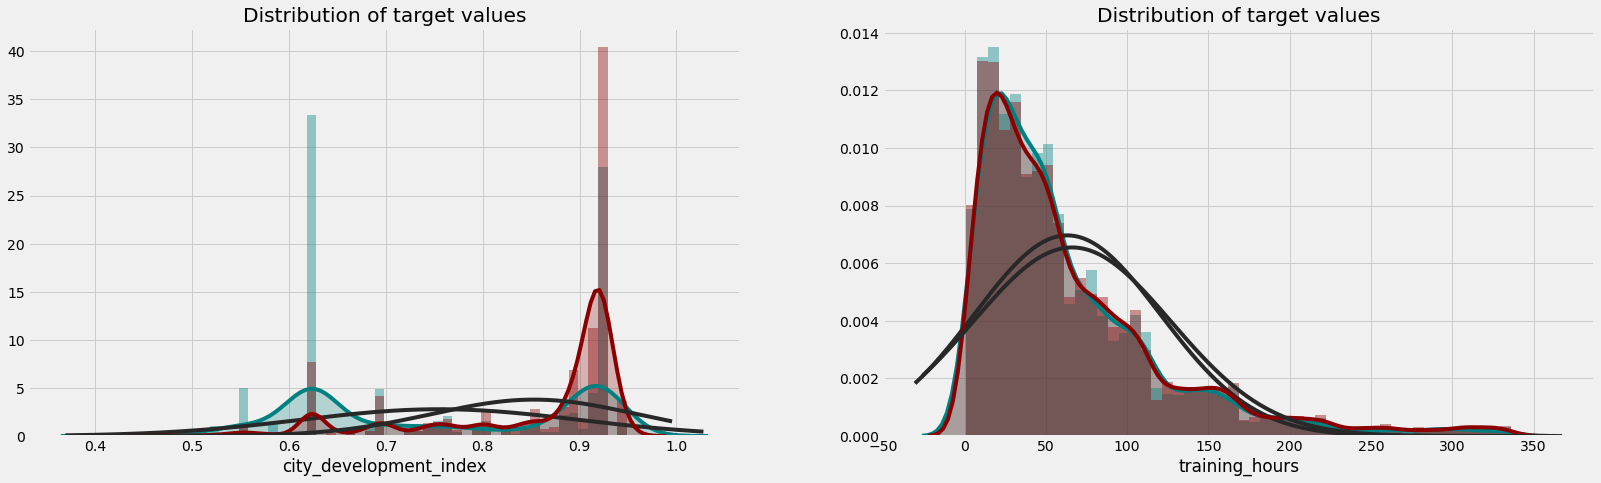

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(25, 7))
sns.distplot(train[train.target==1].city_development_index,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='teal', ax=axs[0])
sns.distplot(train[train.target==0].city_development_index,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='darkred', ax=axs[0])
axs[0].set_title('Distribution of target values')

sns.distplot(train[train.target==1].training_hours,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='teal', ax=axs[1])
sns.distplot(train[train.target==0].training_hours,bins=50,  fit=norm,kde=True,kde_kws={"shade": True},norm_hist=True,  color='darkred', ax=axs[1])
axs[1].set_title('Distribution of target values')
plt.show()

In [10]:
del train['enrollee_id']
del test['enrollee_id']

### Cats

In [11]:
cats = nominals+ordinals


def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[]
    for c in cat_cols:
        #print("column:" , c ,"--Uniques:" , train[c].unique(), "--Cardinality:", train[c].unique().size)
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum())
        
    d['"feat"'] = cl;d["uniques"] = u; d["cardinality"] = s; d["nans"] = nans
    return d

plt.style.use('fivethirtyeight')
catanadf = analyse_cats(train, cats)
catanadf

,"""feat""",uniques,cardinality,nans
0,city_nom,"[city_103, city_40, city_21, city_115, city_162, city_176, city_160, city_46, city_61, city_114, city_13, city_159, city_102, city_67, city_100, city_16, city_71, city_104, city_64, city_101, city_83, city_105, city_73, city_75, city_41, city_11, city_93, city_90, city_36, city_20, city_57, city...",123,0
1,gender_nom,"[Male, nan, Female, Other]",4,4508
2,relevent_experience_nom,"[Has relevent experience, No relevent experience]",2,0
3,enrolled_university_nom,"[no_enrollment, Full time course, nan, Part time course]",4,386
4,major_discipline_nom,"[STEM, Business Degree, nan, Arts, Humanities, No Major, Other]",7,2813
5,company_type_nom,"[nan, Pvt Ltd, Funded Startup, Early Stage Startup, Other, Public Sector, NGO]",7,6140
6,education_level_ord,"[Graduate, Masters, High School, nan, Phd, Primary School]",6,460
7,experience_ord,"[>20, 15, 5, <1, 11, 13, 7, 17, 2, 16, 1, 4, 10, 14, 18, 19, 12, 3, 6, 9, 8, 20, nan]",23,65
8,company_size_ord,"[nan, 50-99, <10, 10000+, 5000-9999, 1000-4999, 10/49, 100-500, 500-999]",9,5938
9,last_new_job_ord,"[1, >4, never, 4, 3, 2, nan]",7,423


### **Missing Values**

In [12]:
pd.DataFrame(train.isna().sum(axis=0)/len(train), columns=['missing percent']).sort_values('missing percent', ascending=False)

,missing percent
company_type_nom,0.320493
company_size_ord,0.309949
gender_nom,0.235306
major_discipline_nom,0.146832
education_level_ord,0.024011
last_new_job_ord,0.022080
enrolled_university_nom,0.020148
experience_ord,0.003393
city_nom,0.000000
city_development_index,0.000000


In [13]:
def null_analysis(df):
  '''
  desc: get nulls for each column in counts & percentages
  arg: dataframe
  return: dataframe
  '''
  null_cnt = df.isnull().sum() # calculate null counts
  null_cnt = null_cnt[null_cnt!=0] # remove non-null cols
  null_percent = null_cnt / len(df) * 100 # calculate null percentages
  null_table = pd.concat([pd.DataFrame(null_cnt), pd.DataFrame(null_percent)], axis=1)
  null_table.columns = ['counts', 'percentage']
  null_table.sort_values('counts', ascending=False, inplace=True)
  return null_table

null_table = null_analysis(train)
#plt.bar(null_table.reset_index(), x='index', y='percentage', text='counts', height=500)
null_table

,counts,percentage
company_type_nom,6140,32.049274
company_size_ord,5938,30.994885
gender_nom,4508,23.530640
major_discipline_nom,2813,14.683161
education_level_ord,460,2.401086
last_new_job_ord,423,2.207955
enrolled_university_nom,386,2.014824
experience_ord,65,0.339284


In [14]:
null_table.reset_index()

,index,counts,percentage
0,company_type_nom,6140,32.049274
1,company_size_ord,5938,30.994885
2,gender_nom,4508,23.530640
3,major_discipline_nom,2813,14.683161
4,education_level_ord,460,2.401086
5,last_new_job_ord,423,2.207955
6,enrolled_university_nom,386,2.014824
7,experience_ord,65,0.339284


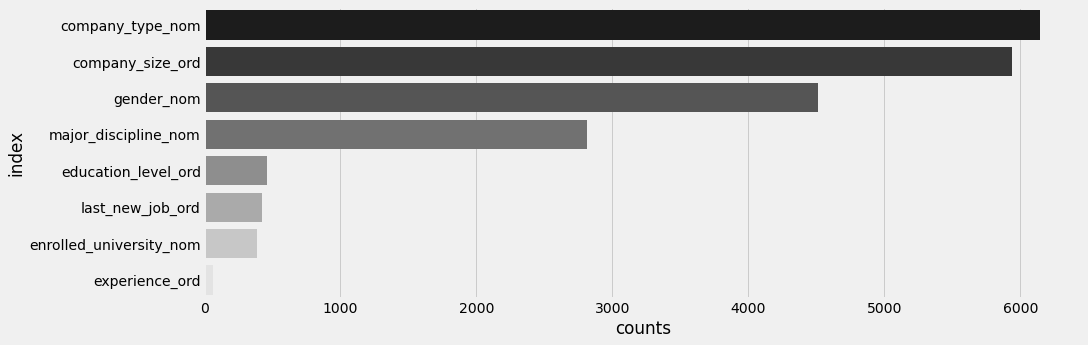

In [15]:
plt.figure(figsize=(14, 5))
sns.barplot(data= null_table.reset_index()[['index', 'counts']], x= 'counts', y='index', palette='gray')

## **1. Label Encoding, Ordinal Encoding**

Label encoding  includes replacing the categories with digits from 1 to n (or 0 to n-1, depending on the implementation),where n is the number of the variable’s distinct categories (the cardinality), and these numbers are assigned arbitrarily.

Advantages of integer (label) encoding
- Straightforward to implement.
- Does not expand the feature space.
- Can work well enough with tree-based algorithms.
- Allows agile benchmarking of machine learning models.

Limitations of integer (label) encoding
- Does not add extra information while encoding.
- Not suitable for linear models.
- Does not handle new categories in the test set automatically.
- Creates an order relationship between the categories.

in following implementation:
- label encoder  will  map nans as a new category so imputation is not a must, So i wont impute nominals and will build new category of nans with label encoder


- through the rest of note book we will find out why **generally** label encoding/ordinal encoding is not suitable for linear model (although it depends on data). Anyway i prefer to encode ordinals by manual mapping and nominal by Scikit.LabelEncoder() if i don't want to apply other techniaues for cat encoding.Because LabelEncoder wont preserve order during mapping and this will confuse  linear models e.g. Logistic Regression.


In [16]:
train = tr_orig.copy()
test = ts_orig.copy()
del train['enrollee_id']
del test['enrollee_id']

In [17]:
for c in ordinals:
    print(c,list(train[c].unique()))

education_level_ord ['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School']
experience_ord ['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4', '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan]
company_size_ord [nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49', '100-500', '500-999']
last_new_job_ord ['1', '>4', 'never', '4', '3', '2', nan]


In [18]:
def OrdMapping(df):
    
    
    education_level_ord_mapping = {'Primary School': 0,'High School': 1,'Graduate': 2 , 'Masters':3,'Phd': 4 }
    experience_ord_mapping= {'<1':0, '1':2, '2':3, '3':4,'4':5, '5':6, '6':7, '7':8, '8':9,'9':10, '10':11, '12':13, '13':14,'14':15, '15':16, '16':17,  '17':18,'18':19, '19':20,'20':21,'>20':22}
    company_size_ord_mapping = {'<10':0 ,'10/49':1,'50-99':2, '100-500':3, '500-999':4, '1000-4999':5,'5000-9999':6, '10000+':7}
    
    last_new_job_ord_mapping = {'never':0,'1':1,'2':2,'3':3,'4':4,'>4':5}
    df['education_level_ord'] = df.education_level_ord.map(education_level_ord_mapping)
    df['experience_ord'] = df.experience_ord.map(experience_ord_mapping)
    df['company_size_ord'] = df.company_size_ord.map(company_size_ord_mapping)
    df['last_new_job_ord'] = df.last_new_job_ord.map(last_new_job_ord_mapping)
     
    return df

train = OrdMapping(train)
test  = OrdMapping(test)


train.head()

,city_nom,city_development_index,gender_nom,relevent_experience_nom,enrolled_university_nom,education_level_ord,major_discipline_nom,experience_ord,company_size_ord,company_type_nom,last_new_job_ord,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,2.0,STEM,22.0,NaN,NaN,1.0,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,2.0,STEM,16.0,2.0,Pvt Ltd,5.0,47,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,2.0,STEM,6.0,NaN,NaN,0.0,83,0.0
3,city_115,0.789,NaN,No relevent experience,NaN,2.0,Business Degree,0.0,NaN,Pvt Ltd,0.0,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,3.0,STEM,22.0,2.0,Funded Startup,4.0,8,0.0


Label encoding nominals:

In [19]:
for c in nominals:
    le = LabelEncoder()
    le.fit(list(train[c].astype(str)) + list(test[c].astype(str)))
    train[c] = le.transform(train[c].astype(str))
    test[c] = le.transform(test[c].astype(str))
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('target mapping :  ',c ,  le_name_mapping)

target mapping :   city_nom {'city_1': 0, 'city_10': 1, 'city_100': 2, 'city_101': 3, 'city_102': 4, 'city_103': 5, 'city_104': 6, 'city_105': 7, 'city_106': 8, 'city_107': 9, 'city_109': 10, 'city_11': 11, 'city_111': 12, 'city_114': 13, 'city_115': 14, 'city_116': 15, 'city_117': 16, 'city_118': 17, 'city_12': 18, 'city_120': 19, 'city_121': 20, 'city_123': 21, 'city_126': 22, 'city_127': 23, 'city_128': 24, 'city_129': 25, 'city_13': 26, 'city_131': 27, 'city_133': 28, 'city_134': 29, 'city_136': 30, 'city_138': 31, 'city_139': 32, 'city_14': 33, 'city_140': 34, 'city_141': 35, 'city_142': 36, 'city_143': 37, 'city_144': 38, 'city_145': 39, 'city_146': 40, 'city_149': 41, 'city_150': 42, 'city_152': 43, 'city_155': 44, 'city_157': 45, 'city_158': 46, 'city_159': 47, 'city_16': 48, 'city_160': 49, 'city_162': 50, 'city_165': 51, 'city_166': 52, 'city_167': 53, 'city_171': 54, 'city_173': 55, 'city_175': 56, 'city_176': 57, 'city_179': 58, 'city_18': 59, 'city_180': 60, 'city_19': 61,

In [20]:
cats = ordinals + nominals

imp = SimpleImputer(strategy='most_frequent')
train[cats] = imp.fit_transform(train[cats])
test[cats]  = imp.transform(test[cats])

train.isnull().sum()


city_nom                   0
city_development_index     0
gender_nom                 0
relevent_experience_nom    0
enrolled_university_nom    0
education_level_ord        0
major_discipline_nom       0
experience_ord             0
company_size_ord           0
company_type_nom           0
last_new_job_ord           0
training_hours             0
target                     0
dtype: int64

In [21]:
target = train.pop('target')
nums = [c for c in train.columns if c not in  cats]


ss = StandardScaler()
train[nums]= ss.fit_transform(train[nums])
test[nums]= ss.fit_transform(test[nums])

### **Logistic Regression**

In [22]:
score_auc = []

oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    lr = LogisticRegression(C=0.1, solver='newton-cg',max_iter=100, random_state=2020, class_weight={0: 1, 1:3})
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = lr.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('train auc:' , roc_auc_score(y_train, y),'val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
    
    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))


fold: 0   - Starting ...
train auc: 0.7518750700991399 val auc: 0.7465905172182334
fold: 1   - Starting ...
train auc: 0.7485694177374875 val auc: 0.7529268028712608
fold: 2   - Starting ...
train auc: 0.7499452997493498 val auc: 0.7493505019884571
--------------------------------------------------
 Model auc:   0.7496226073593171


In [23]:
roc_auc_score(answer, pred_lr)

0.7386934785719396

### **QuadraticDiscriminantAnalysis**

In [24]:
score_auc = []

oof_qd = np.zeros(len(train))
pred_qd = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target[train_ind], target[val_ind]
    
    qd =   QuadraticDiscriminantAnalysis()
    qd.fit(trn_data, y_train)
    oof_qd[val_ind] = qd.predict(val_data)
    y = qd.predict(trn_data)
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_qd[val_ind]))
       
    score_auc.append(roc_auc_score(y_val, oof_qd[val_ind]))
                            
    pred_qd += qd.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))


fold: 0   - Starting ...
train auc: 0.6824049282306284
val auc: 0.674879685290472
fold: 1   - Starting ...
train auc: 0.6842803687528868
val auc: 0.6837723535128404
fold: 2   - Starting ...
train auc: 0.6784523199993595
val auc: 0.6823025002411252
fold: 3   - Starting ...
train auc: 0.6843027432615811
val auc: 0.6805549082859411
fold: 4   - Starting ...
train auc: 0.680065898588901
val auc: 0.6779210873158619
--------------------------------------------------
 Model auc:   0.6798861069292481


In [25]:
roc_auc_score(answer, pred_qd)

0.6863915942262288

## **2. One-Hot Encoding, Dummy Encoding**

In One-Hot method, we map each category to a vector that contains 1 and 0 denoting the presence of the feature or not. The number of vectors depends on the categories which we want to keep. For high cardinality features, this method produces a lot of columns that slows down the learning significantly. There is a buzz between one hot encoding and dummy encoding and when to use one. They are much alike except one hot encoding produces the number of columns equal to the number of categories and dummy producing is one less. This should ultimately be handled by the modeler accordingly in the validation process.



![oh1](https://www.renom.jp/notebooks/tutorial/preprocessing/onehot/ConvertCategorical_en.png)

Dummy encocoding scheme is similar to one-hot encoding. This categorical data encoding method transforms the categorical variable into a set of binary variables (also known as dummy variables). In the case of one-hot encoding, for N categories in a variable, it uses N binary variables. The dummy encoding is a small improvement over one-hot-encoding. Dummy encoding uses N-1 features to represent N labels/categories.

To understand this better let’s see the image below. Here we are coding the same data using both one-hot encoding and dummy encoding techniques. While one-hot uses 3 variables to represent the data whereas dummy encoding uses 2 variables to code 3 categories.

![dum](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/08/Screenshot-from-2020-08-12-18-28-24-768x452.png)

Advantages of one-hot encoding

- Does not assume the distribution of categories of the categorical variable.
- Keeps all the information of the categorical variable.
- Not so Suitable for tree based models.

Limitations of one-hot encoding
- Expands the feature space.
- Does not add extra information while encoding.
- Many dummy variables may be identical, and this can introduce redundant information.

I will use dummy encoding:

In [26]:
train = tr_orig.copy()
test = ts_orig.copy()


target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

train.fillna('UnKnown', inplace=True)
test.fillna('UnKnown', inplace=True)



data = pd.concat([train, test], axis=0)
data = pd.get_dummies(data)
train = data.iloc[:len(train), ]
test = data.iloc[:len(test), ]



In [27]:
missing = test.isnull().sum()
print(missing[missing>0])

train.head()

Series([], dtype: int64)


,city_development_index,training_hours,city_nom_city_1,city_nom_city_10,city_nom_city_100,city_nom_city_101,city_nom_city_102,city_nom_city_103,city_nom_city_104,city_nom_city_105,...,company_type_nom_Public Sector,company_type_nom_Pvt Ltd,company_type_nom_UnKnown,last_new_job_ord_1,last_new_job_ord_2,last_new_job_ord_3,last_new_job_ord_4,last_new_job_ord_>4,last_new_job_ord_UnKnown,last_new_job_ord_never
0,0.920,36,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
1,0.776,47,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0.624,83,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.789,52,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0.767,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [28]:
train.shape, test.shape

((19158, 194), (2129, 194))

### **LinearSVC**

In [29]:

score_auc = []

oof_svm = np.zeros(len(train))
pred_svm = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target[train_ind], target[val_ind]
    
    lsvm =   LinearSVC(C=.0001, random_state=2020)
    lsvm.fit(trn_data, y_train)
    oof_svm[val_ind] = lsvm.predict(val_data)
    y = lsvm.predict(trn_data)
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_svm[val_ind]))
    score_auc.append(roc_auc_score(y_val, oof_svm[val_ind]))
                           
    pred_svm += lsvm.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))


fold: 0   - Starting ...
train auc: 0.5172872962053183
val auc: 0.5130854976402606
fold: 1   - Starting ...
train auc: 0.515933845769411
val auc: 0.5151775478494656
fold: 2   - Starting ...
train auc: 0.5147075774248933
val auc: 0.5195629900983973
fold: 3   - Starting ...
train auc: 0.516802809781018
val auc: 0.5132728702604694
fold: 4   - Starting ...
train auc: 0.5150985818056035
val auc: 0.5148535633405907
--------------------------------------------------
 Model auc:   0.5151904938378367


In [30]:
roc_auc_score(answer, pred_svm)

0.5015058220648207

seems we lost informations by dummy encoding

## **3. Frequency Encoding**

It is a way to utilize the frequency of the categories as labels. In the cases where the frequency is related somewhat with the target variable, it helps the model to understand and assign the weight in direct and inverse proportion, depending on the nature of the data.
Replace the categories by the count of the observations that show that category in the dataset. Similarly, we can replace the category by the frequency -or percentage- of observations in the dataset. 



Advantages of Count or Frequency encoding
- Straightforward to implement.
- Does not expand the feature space.
- Can work well with tree-based algorithms.

Limitations of Count or Frequency encoding

- Does not handle new categories in the test set automatically.
- We can lose valuable information if there are two different categories with the same amount of observations count—this is because we replace them with the same number.

Here we will add frequency encoded features to labeled encoded features:

In [31]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']


In [32]:
daset = pd.concat([train, test], axis=0)


for c in (cats):
    daset[c+'_freq'] = daset[c].map(daset.groupby(c).size() / daset.shape[0])
    indexer = pd.factorize(daset[c], sort=True)[1]
    daset[c] = indexer.get_indexer(daset[c])

train= daset.iloc[:len(train) , ]
test= daset.iloc[len(train): , ]
cols=train.columns
train.shape, test.shape

((19158, 22), (2129, 22))

In [33]:
train.isnull().sum()

city_nom                           0
city_development_index             0
gender_nom                         0
relevent_experience_nom            0
enrolled_university_nom            0
education_level_ord                0
major_discipline_nom               0
experience_ord                     0
company_size_ord                   0
company_type_nom                   0
last_new_job_ord                   0
training_hours                     0
education_level_ord_freq         460
experience_ord_freq               65
company_size_ord_freq           5938
last_new_job_ord_freq            423
city_nom_freq                      0
gender_nom_freq                 4508
relevent_experience_nom_freq       0
enrolled_university_nom_freq     386
major_discipline_nom_freq       2813
company_type_nom_freq           6140
dtype: int64

In [34]:
imp = SimpleImputer(strategy='constant')
train = imp.fit_transform(train)
test  = imp.transform(test)

ss = StandardScaler()
train = ss.fit_transform(train)
test  = ss.transform(test)

### **Logistic Regression**

In [35]:
score_auc = []

oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train[train_ind], train[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    lr = LogisticRegression(C= 1,max_iter=200, random_state=2020, class_weight={0: 1, 1:3})
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = lr.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
    
                        
    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))


fold: 0   - Starting ...
train auc: 0.7927518439349438
val auc: 0.7845561421768957
fold: 1   - Starting ...
train auc: 0.7908308592270505
val auc: 0.7879848895080325
fold: 2   - Starting ...
train auc: 0.7879599680297054
val auc: 0.7930706148598645
--------------------------------------------------
 Model auc:   0.788537215514931


In [36]:
roc_auc_score(answer, pred_lr)

0.7836836856979322

Good score for logistic regression

## **4. Target Encoding - Mean Likelihood Encoding ,"The Right Way !"**

Mean encoding means replacing the category with the mean target value for that category. We start by grouping each category alone, and for each group, we calculate the mean of the target in the corresponding observations. Then we assign that mean to that category. Thus, we encoded the category with the mean of the target.
Here’s a detailed illustration of mean encoding:


![te](https://miro.medium.com/max/653/1*gbKFmnAGdnaatRm011RLxA.png)




Advantages of Mean encoding

- Does not expand the feature space.
- Creates a monotonic relationship between categories and the target.

Limitations of Mean encoding
- May lead to overfitting.
- May lead to a possible loss of value if two categories have the same mean as the target—in these cases, the same number replaces the original.

According to: 
 - https://maxhalford.github.io/blog/target-encoding/
 - https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b 
 
we have better implement target encoding through KFold and  with smoothing.

min_samples_leaf define a threshold where prior and target mean (for a given category value) have the same weight. Below the threshold prior becomes more important and above mean becomes more important.How weight behaves against value counts is controlled by smoothing parameter

In [37]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

In [38]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [39]:

smoothing =1
import category_encoders as ce
oof = pd.DataFrame([])
from sklearn.model_selection import StratifiedKFold
for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2020, shuffle=True).split(train, target):
    ce_target_encoder = ce.TargetEncoder(cols = cats, smoothing=smoothing)
    ce_target_encoder.fit(train.iloc[tr_idx, :], target.iloc[tr_idx])
    oof = oof.append(ce_target_encoder.transform(train.iloc[oof_idx, :]), ignore_index=False)
ce_target_encoder = ce.TargetEncoder(cols = cats, smoothing=smoothing)
ce_target_encoder.fit(train, target);  train = oof.sort_index(); test = ce_target_encoder.transform(test)


### **Logistic Regression**

In [40]:
score_auc = []

oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    lr = LogisticRegression(C= 0.1,max_iter=100, random_state=2020, class_weight={0: 1, 1:3})
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = lr.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
    
    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
                           
    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits
    
print(' Model auc: -------> ', np.mean(score_auc))


fold: 0   - Starting ...
train auc: 0.7929377249174203
val auc: 0.7835950430581811
fold: 1   - Starting ...
train auc: 0.7866845172061454
val auc: 0.7957620782723204
fold: 2   - Starting ...
train auc: 0.7900903359108432
val auc: 0.7891252883170745
 Model auc: ------->  0.789494136549192


In [41]:
roc_auc_score(answer, pred_lr)

0.7914755044000858

## **5. Hash Encoding**

To understand Hash encoding it is necessary to know about hashing. Hashing is the transformation of arbitrary size input in the form of a fixed-size value. We use hashing algorithms to perform hashing operations i.e to generate the hash value of an input. Further, hashing is a one-way process, in other words, one can not generate original input from the hash representation.

Hashing has several applications like data retrieval, checking data corruption, and in data encryption also. We have multiple hash functions available for example Message Digest (MD, MD2, MD5), Secure Hash Function (SHA0, SHA1, SHA2), and many more.

Just like one-hot encoding, the Hash encoder represents categorical features using the new dimensions. Here, the user can fix the number of dimensions after transformation using n_component argument. Here is what we mean – A feature with 5 categories can be represented using N new features similarly, a feature with 100 categories can also be transformed using N new features. 

By default, the Hashing encoder uses the md5 hashing algorithm but a user can pass any algorithm of his choice. 

In [42]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

data = pd.concat([train, test], axis=0)


using https://contrib.scikit-learn.org/category_encoders/index.html#

In [43]:
#Create object for hash encoder
encoder=ce.HashingEncoder(cols=cats,n_components=6)
data = encoder.fit_transform(data)
train = data.iloc[:len(train), ]
test = data.iloc[len(train):, ]


### **Logistic Regression**

In [44]:
score_auc = []

oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    lr = LogisticRegression(C= 0.1,max_iter=200, random_state=2020, class_weight={0: 1, 1:3})
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = lr.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
      
    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
    
                        
    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits
    
print(' Model auc: -------> ', np.mean(score_auc))


fold: 0   - Starting ...
train auc: 0.7543950199272242
val auc: 0.7578537144024277
fold: 1   - Starting ...
train auc: 0.7593256451160089
val auc: 0.7383210557320962
fold: 2   - Starting ...
train auc: 0.7513579550339317
val auc: 0.7689983102866371
fold: 3   - Starting ...
train auc: 0.7560451308726017
val auc: 0.7503604615390318
fold: 4   - Starting ...
train auc: 0.754486372570182
val auc: 0.7572854820146513
 Model auc: ------->  0.7545638047949688


In [45]:
roc_auc_score(answer, pred_lr)

0.7484293392716607

Since Hashing transforms the data in lesser dimensions, it may lead to loss of information. Another issue faced by hashing encoder is the collision. Since here, a large number of features are depicted into lesser dimensions, hence multiple values can be represented by the same hash value, this is known as a collision.

Moreover, hashing encoders have been very successful in some Kaggle competitions. It is great to try if the dataset has high cardinality features.

## **6. Encoding using “Weight of Evidence”**



Weight of evidence (WOE) is a technique used to encode categorical variables for classification.
The rule is simple; WOE is the natural logarithm (ln) of the probability that the target equals 1 divided by the probability of the target equals 0.
Here is a mathematic formula : WOE = ln (p(1) / p(0)).
Where p(1) is the probability of the target being 1, and p(0) is the probability of the target being 0.
If the result is negative, you can change the sign of the output.
The WOE is bigger than 0 if the probability of the target being 0 is more significant and smaller than 0 when the probability of the target being 1 is more significant.
This way, the WOE transformation creates an excellent visual representation of the variable. By looking at the WOE encoded variable, you can see which category favors the target being 0 or 1.

![we](https://miro.medium.com/max/412/1*tCDfdEZA9G7zHZV3bGvCfA.png)

Advantages of the Weight of evidence encoding
- Creates a monotonic relationship between the target and the variables.
- Orders the categories on a “logistic” scale, which is natural for logistic regression.
- We can compare the transformed variables because they are on the same scale. Therefore, it’s possible to determine which one is more predictive.

Limitations of the Weight of evidence encoding
- May lead to overfitting.
- Not defined when the denominator is 0.

In [46]:
train = tr_orig.copy()
test = ts_orig.copy()
target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

using https://contrib.scikit-learn.org/category_encoders/index.html#

In [47]:
import category_encoders as ce

encoder = ce.WOEEncoder(cols=cats, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', random_state=42, randomized=False, sigma=0.05, regularization=1.0)

encoder.fit(train, target)
train = encoder.transform(train)
test = encoder.transform(test)



ss = StandardScaler()
train = ss.fit_transform(train)
test  = ss.transform(test)

### LogisticRegression

In [48]:
score_auc = []

oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train[train_ind], train[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    lr = LogisticRegression(C= 1,max_iter=100, random_state=2020, class_weight={0: 1, 1:3})
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = lr.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
                            
    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits
    
print(' Model auc: -------> ', np.mean(score_auc))


fold: 0   - Starting ...
train auc: 0.8039925358173848
val auc: 0.7937824293615048
fold: 1   - Starting ...
train auc: 0.8009373630139845
val auc: 0.7990355275543342
fold: 2   - Starting ...
train auc: 0.7968033799040073
val auc: 0.807161328125819
 Model auc: ------->  0.7999930950138859


In [49]:
roc_auc_score(answer, pred_lr)

0.7942590952994206

### QuadraticDiscriminantAnalysis

In [50]:
score_auc = []

oof_qd = np.zeros(len(train))
pred_qd = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train[train_ind], train[val_ind]
    y_train, y_val = target[train_ind], target[val_ind]
    
    qd =   QuadraticDiscriminantAnalysis()
    qd.fit(trn_data, y_train)
    oof_qd[val_ind] = qd.predict(val_data)
    y = qd.predict(trn_data)
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_qd[val_ind]))
      
    score_auc.append(roc_auc_score(y_val, oof_qd[val_ind]))
                           
    pred_qd += qd.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))


fold: 0   - Starting ...
train auc: 0.7419266522833341
val auc: 0.7294715754680199
fold: 1   - Starting ...
train auc: 0.7405669917418107
val auc: 0.7347133396570085
fold: 2   - Starting ...
train auc: 0.7390490619057082
val auc: 0.7372981599870428
fold: 3   - Starting ...
train auc: 0.7409702081614914
val auc: 0.7325892564571213
fold: 4   - Starting ...
train auc: 0.7342974217066227
val auc: 0.7505321163046407
--------------------------------------------------
 Model auc:   0.7369208895747666


In [51]:
roc_auc_score(answer, pred_qd)

0.7407761411604781

## **6. CatBoost and Cats**

When running machine learning algorithms, simply assigning numbers to categorical variables work if a category has only two levels. This is the case for gender (male/female), bought a product (yes/no), attended a course (yes/no). When a category has several levels, as with nationality, assigning numbers to each level implies an order of the levels. This means that one level of the category has a lower rank than another level. While this makes sense for ordinal variables (e.g., preferences of food items or educational degree), it is a wrong assumption for nominal variables such as color preferences, nationality, residential city specially when we use linear Algorithms. Algorithms like CatBoost have different perspective to solve this problem.  

We can use CatBoost without any explicit pre-processing to convert categories into numbers. CatBoost converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features.

In detail , Catboost calculates for every category of a nominal variable , a value (target-based statistic). This is done using a number of steps:
We begin with one categorical feature (e.g., Nationality). This is called x.
In one randomly chosen row (k-th row in the training data set), we exchange one random level of this categorical feature (i-th level of x) with a number (e.g., Dutch by 5)
This number (in our example 5) is usually based on the target variable (the one we want to predict) conditional on the category level. In other words, the target number is based on the expected outcome variable.
A splitting attribute is used to create two sets of the training data: One set that has all categories (e.g., German, French, Indian etc) who will have greater target variable than the one computed in step 3, and the other set with smaller target variables.

![catb](https://developer-blogs.nvidia.com/wp-content/uploads/2018/12/catboost_hero.png)

In their [paper](http://learningsys.org/nips17/assets/papers/paper_11.pdf) authors describe how catboost is dealing with categorical features. The standard way is to compute some statistics, such as median, based on the label values of the category. However, this creates problems if there is only one example for a label value. In this case, the numerical value of the category would be the same than the label value. For example if in our example with nationalities, the category Belgian is assigned the value 2, and there is only 1 Belgian student, this student would get the value 2 for nationality. This can create problems of overfitting.

To avoid this problem, the authors designed a solution which involves randomly changing the order of rows in the complete data set. We perform a random permutation of the data set and for each example we compute average label value for the example with the same category value placed before the given one in the permutation .In their paper they also describe how different features are combined to create a new feature. Think about it, every individual observations of categorical and numerical data points describe one observation. The chances that two observations are exactly identical is slim. Hence, different categorical values and numerical values could be combined to create a unique merged categorical variable which contains all the different individual choices. While this might sound easy, doing this for all potential types of combinations will be computational intensive.
Another way to combine different features is to do a greedy search at every tree split. Catboost does this by combining all categorical and numerical values at the current tree with all categorical values in the data set.

Transforming categorical features to numerical features methods are:


- Borders
- Buckets
- BinarizedTargetMeanValue
- Counter


 You can read more about it [here](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html).

In [52]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

train.fillna('UnKnown', inplace=True)
test.fillna('UnKnown', inplace=True)

categorical_features_indices = np.where(train.dtypes == 'object')[0]
categorical_features_indices

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [53]:

cat_score = []
# Split data with kfold
kfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=2018)
train_features = train.columns
# Make importance dataframe
importances = pd.DataFrame()

oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(train, target)):
    X_train, y_train = train.iloc[trn_idx], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx], target.iloc[val_idx]
    
    # CatBoost Regressor estimator
    model = cb.CatBoostClassifier(
        learning_rate = 0.01,
        iterations = 2000,
        eval_metric = 'AUC',
        allow_writing_files = False,
        od_type = 'Iter',
        bagging_temperature = 0.8,
        class_weights = [0.3, 1], 
        depth = 6,
        od_wait = 20,
        silent = False
    )
    
    # Fit
    model.fit(
        X_train, y_train,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=100,
        early_stopping_rounds=100
    )
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = model.get_feature_importance()
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict_proba(X_valid)[:, 1]
    cat_score.append(roc_auc_score(y_valid, oof_preds[val_idx]))
    test_preds = model.predict_proba(test)[:, 1]
    sub_preds += test_preds / kfolds.n_splits
    
print(np.mean(cat_score))


0:	test: 0.7814371	test1: 0.7771193	best: 0.7771193 (0)	total: 98.5ms	remaining: 3m 16s
100:	test: 0.8106067	test1: 0.7988123	best: 0.7988123 (100)	total: 3.66s	remaining: 1m 8s
200:	test: 0.8191841	test1: 0.8011868	best: 0.8011868 (200)	total: 7.28s	remaining: 1m 5s
300:	test: 0.8249301	test1: 0.8028758	best: 0.8028758 (300)	total: 11s	remaining: 1m 2s
400:	test: 0.8279264	test1: 0.8039108	best: 0.8039108 (400)	total: 14.8s	remaining: 58.8s
500:	test: 0.8305463	test1: 0.8042950	best: 0.8043412 (491)	total: 18.6s	remaining: 55.5s
600:	test: 0.8320781	test1: 0.8048230	best: 0.8048230 (600)	total: 22.2s	remaining: 51.6s
700:	test: 0.8334625	test1: 0.8051692	best: 0.8051809 (697)	total: 25.9s	remaining: 48s
800:	test: 0.8347925	test1: 0.8054508	best: 0.8054508 (800)	total: 29.7s	remaining: 44.5s
900:	test: 0.8364473	test1: 0.8056657	best: 0.8056657 (900)	total: 33.7s	remaining: 41.2s
1000:	test: 0.8378791	test1: 0.8058976	best: 0.8059263 (988)	total: 37.5s	remaining: 37.5s
1100:	test: 0.8

In [54]:
roc_auc_score(answer, sub_preds)

0.7992533492523433

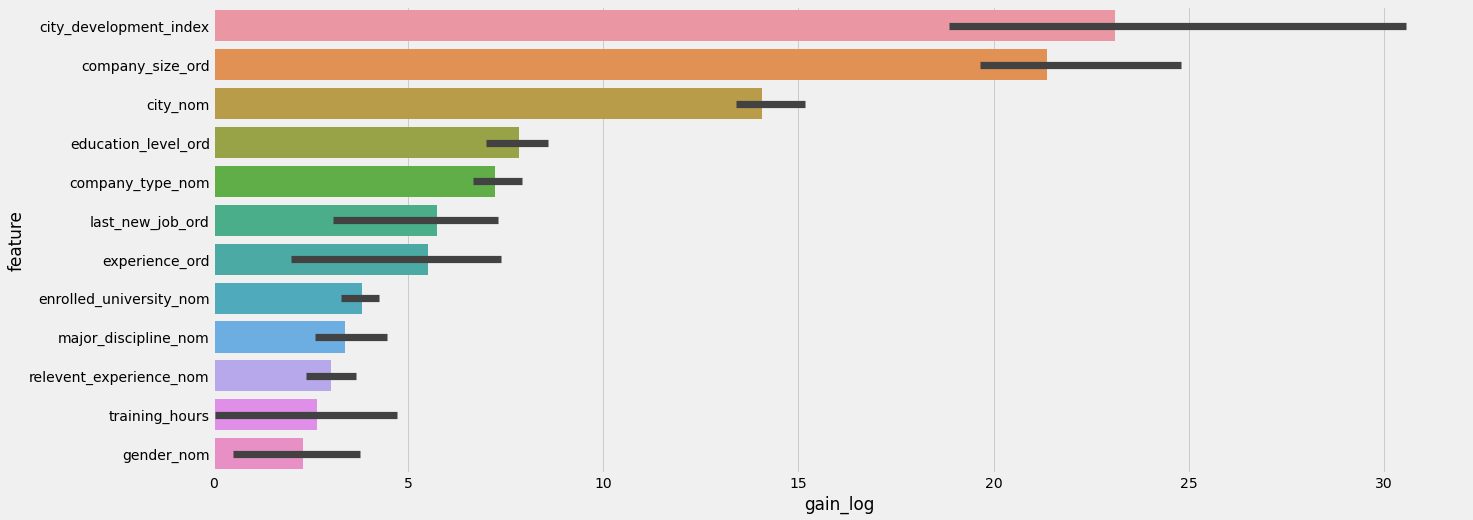

In [55]:
importances['gain_log'] = importances['gain']
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(20, 8))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

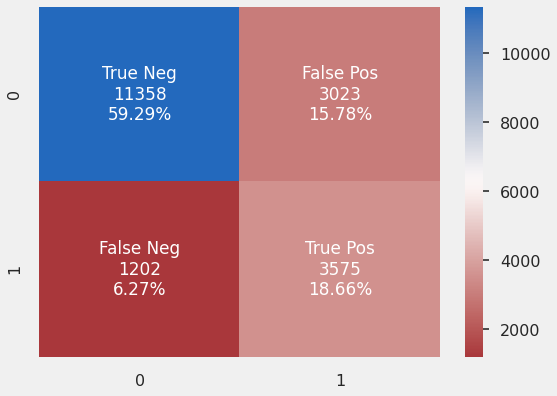

In [56]:
oof_cb_rnd = np.where(oof_preds>.50, 1, 0)
cf_matrix = confusion_matrix(target, (oof_cb_rnd)) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
plt.style.use('seaborn-poster')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='vlag_r')

## **7. LightGBM and Cats**

Lgb sorts the categories according to the training objective at each split. More specifically, LightGBM sorts the histogram (for a categorical feature) according to its accumulated values (sum_gradient / sum_hessian) and then finds the best split on the sorted histogram. So the split can be made based on the variable being of one specific level or any subset of levels, so you have 2^N splits available in comparision with e.g of 4 for OHE.

The algorithm behind above mechanism is Fisher (1958) to find the optimal split over categories. http://www.csiss.org/SPACE/workshops/2004/SAC/files/fisher.pdf

Folowing we specified categorical feats for lgb .  As lgb is using target encoding i used 2 additive parameters 'min_data_per_group' and 'cat_smooth' and changed default values. Thease parameters help to prevent overfitting, similar to what we did with target encoding for Logistic regression throug KFold. 



In [57]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

In [58]:
cats = [c for c in train.columns if train[c].dtypes =='object']

As lgb is inherently tree based we can convert ordinals by LabelEncoder like nominals and then specify them for lgb: 

In [59]:
for c in cats:
    le=LabelEncoder()
    le.fit(list(train[c].astype('str')) + list(test[c].astype('str')))
    train[c] = le.transform(list(train[c].astype(str))) 
    test[c] = le.transform(list(test[c].astype(str))) 
train.head()

,city_nom,city_development_index,gender_nom,relevent_experience_nom,enrolled_university_nom,education_level_ord,major_discipline_nom,experience_ord,company_size_ord,company_type_nom,last_new_job_ord,training_hours
0,5,0.920,1,0,3,0,5,21,8,6,0,36
1,77,0.776,1,1,3,0,5,6,4,5,4,47
2,64,0.624,3,1,0,0,5,15,8,6,6,83
3,14,0.789,3,1,2,0,1,20,8,5,6,52
4,50,0.767,1,0,3,2,5,21,4,1,3,8


Note:
1. Lgb will handle nan values automatically
2. 'categorical_feature' parameter get cats directly (Numeric)
3. We used 'unbalance'parameter for handling imbalanced data by lgb (see confusion matrix below), You can use scale_pos_weight too like XGBoost.

In [60]:

lgb_params = {
    
 'objective': 'binary', 
 'boosting': 'gbdt', 
 'bagging_fraction': 0.9,
 'bagging_frequency': 1,
 'cat_smooth': 70,
 'feature_fraction': 0.9,
 'learning_rate': 0.01,
 'min_child_samples': 20,
 'min_data_per_group': 100,
 'num_leaves': 18,
 #'reg_alpha': 1.,
 #'reg_lambda': 3., 
 'metric':'auc', 
 'unbalance':True}
    
    
    
    


oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

scores = []

feature_importances_gain = pd.DataFrame()
feature_importances_gain['feature'] = train.columns

feature_importances_split = pd.DataFrame()
feature_importances_split['feature'] = train.columns


folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_, (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print("fold : ---------------------------------------", fold_)
    trn_data = lgb.Dataset(train.iloc[train_ind], label=target.iloc[train_ind], categorical_feature=cats) #-------> Specify Categorical feature for lgb
    val_data= lgb.Dataset(train.iloc[val_ind], label=target.iloc[val_ind], categorical_feature=cats)  #-------> Specify Categorical feature for lgb
    
    lgb_clf = lgb.train(lgb_params, trn_data, num_boost_round=1000, valid_sets=(trn_data, val_data), verbose_eval=100, early_stopping_rounds=100)
    oof_lgb[val_ind] = lgb_clf.predict(train.iloc[val_ind], num_iteration= lgb_clf.best_iteration)
    print("fold:", fold_, "roc_auc ==", roc_auc_score(target.iloc[val_ind], oof_lgb[val_ind]))
    scores.append(roc_auc_score(target.iloc[val_ind], oof_lgb[val_ind]))
    
    feature_importances_gain['fold_{}'.format(fold_ + 1)] = lgb_clf.feature_importance(importance_type='gain')
    feature_importances_split['fold_{}'.format(fold_ + 1)] = lgb_clf.feature_importance(importance_type='split')
    
    pred_lgb += lgb_clf.predict(test, num_iteration=lgb_clf.best_iteration)/folds.n_splits
    
print(' \\\\\\\\\\\\\\\ model roc_auc ////////////// : ' , np.mean(scores))
    
np.save('oof_lgb', oof_lgb)
np.save('pred_lgb', pred_lgb)

fold : --------------------------------------- 0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.822134	valid_1's auc: 0.794678
[200]	training's auc: 0.832718	valid_1's auc: 0.796661
[300]	training's auc: 0.84273	valid_1's auc: 0.797445
Early stopping, best iteration is:
[282]	training's auc: 0.84112	valid_1's auc: 0.797658
fold: 0 roc_auc == 0.797658137933681
fold : --------------------------------------- 1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.818825	valid_1's auc: 0.800851
[200]	training's auc: 0.830765	valid_1's auc: 0.802899
Early stopping, best iteration is:
[164]	training's auc: 0.826457	valid_1's auc: 0.803769
fold: 1 roc_auc == 0.8037692504030374
fold : --------------------------------------- 2
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.81674	valid_1's auc: 0.804528
[200]	training's auc: 0.827993	valid_1's auc: 0.806928
[300]	training's auc: 0.83897	

In [61]:
roc_auc_score(answer, pred_lgb)

0.7971846605137012

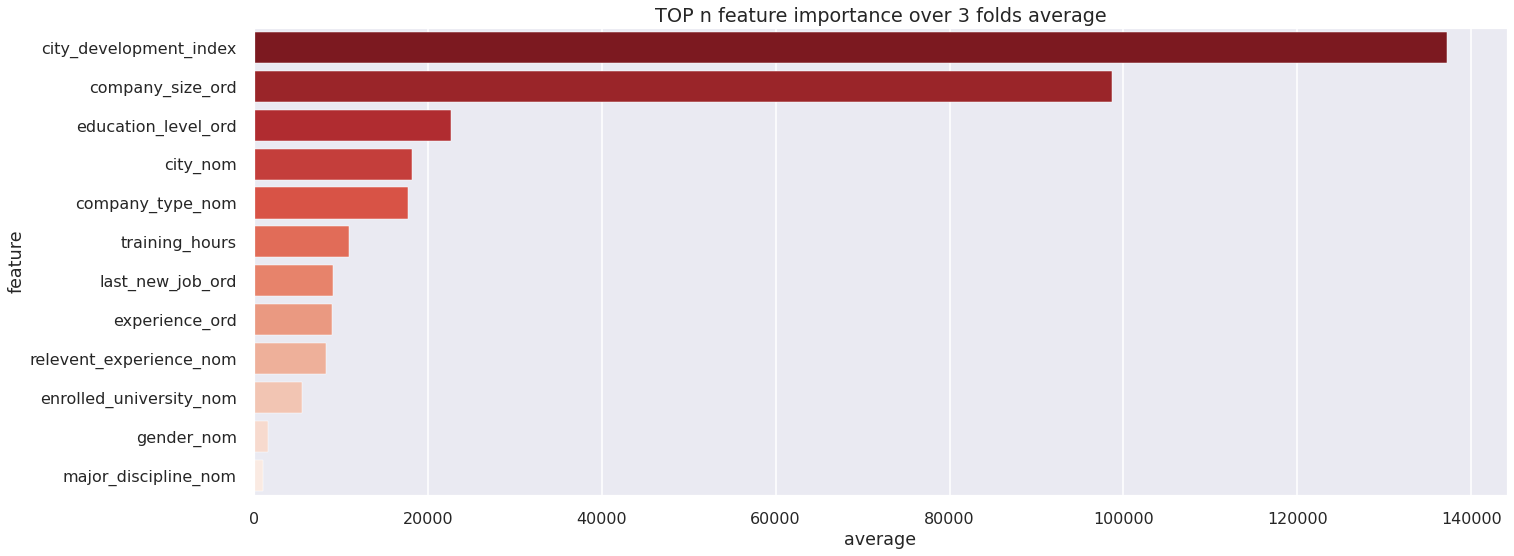

In [62]:
feature_importances_gain['average'] = feature_importances_gain[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances_gain.to_csv('feature_importances.csv')

plt.figure(figsize=(20, 8))
sns.barplot(data=feature_importances_gain.sort_values(by='average', ascending=False).head(100),palette='Reds_r',  x='average', y='feature');
plt.title('TOP n feature importance over {} folds average'.format(folds.n_splits));

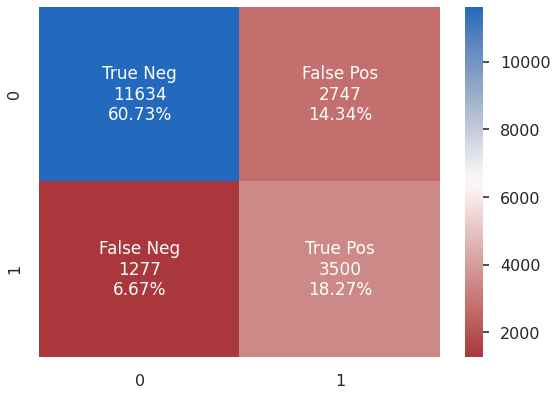

In [63]:
oof_lgb_rnd = np.where(oof_lgb>.50, 1, 0)
cf_matrix = confusion_matrix(target, (oof_lgb_rnd)) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
plt.style.use('seaborn-poster')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='vlag_r')

### **Conclusion**
- The results shows we gained acceptable results as these models are base models.In most cases we handled imbalanced data with class weight. Potential improvement exists for Logistic Regression, Lightgbm and CatBoost.
- It is interesting we could get a competitive result from LogisticRegression by applying weght of evidence and target encoding (.7942 auc and .7915 ) which in comaprision of CatBoost and LightGBM (.7992 auc and .7971) are good performance
- According to CB and LGB feature importance we can see 'city_development_index', 'company_size' and 'education_level' along side with 'city' are most important factor in hob changes. Data scientists in cities with better development index which work in higher size of company don't tend to change their jobs (corr is negative)